In [53]:
from xmlrpc.client import APPLICATION_ERROR

from IPython.core.display import display_png
from pandas import read_parquet
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
from datetime import datetime

# Full Version


BEST SHARPE: 1.397
BEST PARAMS (rsi_p, rsi_n, upper_z, lower_z, exit):
(14, 30, np.float64(0.6), np.float64(-0.6), np.float64(0.18205128205128207))

===== PERFORMANCE SUMMARY =====
Strategy Annual Return: 29.26%
Strategy Annual Risk  : 20.95%
Strategy Sharpe       : 1.40

Stock Annual Return   : 1.56%
Stock Annual Risk     : 31.89%


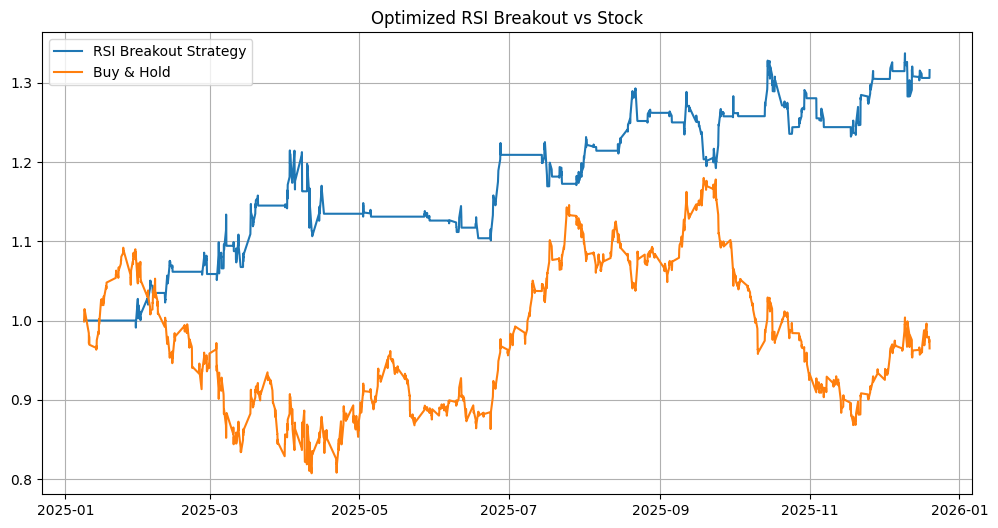

<Axes: xlabel='Datetime'>

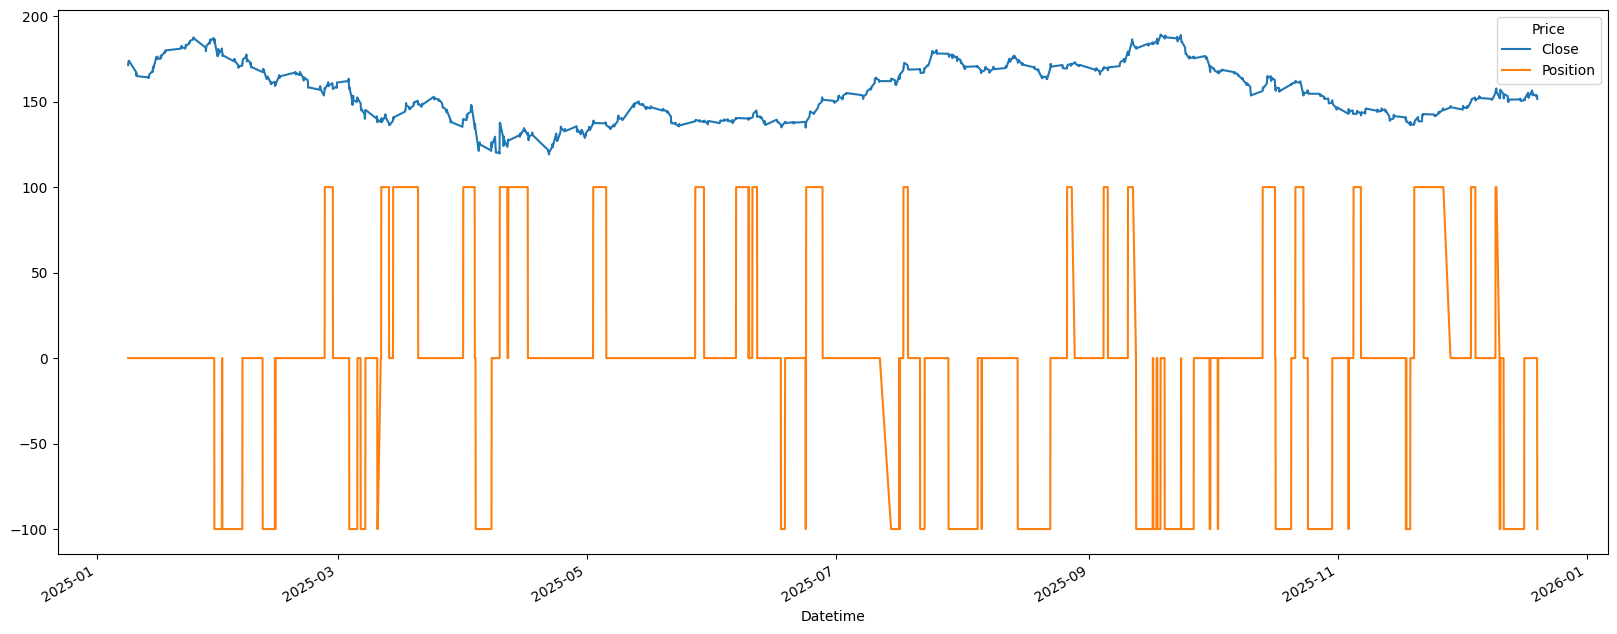

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# DOWNLOAD DATA ONCE
# =====================================================
ticker = "BX"
start = "2025-01-01"
end = "2025-12-20"
interval = "1h"

df_base = yf.download(
    ticker,
    start=start,
    end=end,
    interval=interval,
    auto_adjust=True,
    progress=False
)

if isinstance(df_base.columns, pd.MultiIndex):
    df_base.columns = df_base.columns.get_level_values(0)

df_base.dropna(inplace=True)

# =====================================================
# STRATEGY FUNCTION
# =====================================================
def rsi_breakout_strategy(
    df,
    rsi_period,
    rsi_norm_window,
    upper_z,
    exit_band,
    vol_window=20,
    vol_quantile=0.5,
    return_cap=0.03,
    transaction_cost=0.0002
):

    df = df.copy()

    # ---------------------------
    # RETURNS
    # ---------------------------
    df["ret"] = df["Close"].pct_change().clip(-return_cap, return_cap)

    # ---------------------------
    # WILDER RSI
    # ---------------------------
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1 / rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / rsi_period, adjust=False).mean()

    rs = avg_gain / avg_loss
    df["RSI"] = 100 - 100 / (1 + rs)

    # ---------------------------
    # NORMALIZED RSI
    # ---------------------------
    mean = df["RSI"].rolling(rsi_norm_window).mean()
    std = df["RSI"].rolling(rsi_norm_window).std()
    df["RSI_z"] = (df["RSI"] - mean) / std

    # ---------------------------
    # VOL REGIME FILTER
    # ---------------------------
    df["vol"] = df["ret"].rolling(vol_window).std()
    vol_th = df["vol"].rolling(100).quantile(vol_quantile)
    df["trade_regime"] = df["vol"] > vol_th

    # ---------------------------
    # SIGNALS
    # ---------------------------
    long_entry = (
        (df["RSI_z"] > upper_z) &
        (df["RSI_z"].shift(1) <= upper_z) &
        (df["trade_regime"])
    )

    short_entry = (
        (df["RSI_z"] < -upper_z) &
        (df["RSI_z"].shift(1) >= -upper_z) &
        (df["trade_regime"])
    )

    long_exit = df["RSI_z"] < exit_band
    short_exit = df["RSI_z"] > -exit_band

    # ---------------------------
    # STATE MACHINE
    # ---------------------------
    position = np.zeros(len(df))
    current_pos = 0

    for i in range(len(df)):
        if current_pos == 0:
            if long_entry.iloc[i]:
                current_pos = 100
            elif short_entry.iloc[i]:
                current_pos = -100
        elif current_pos == 100:
            if long_exit.iloc[i] or short_entry.iloc[i]:
                current_pos = 0
        elif current_pos == -100:
            if short_exit.iloc[i] or long_entry.iloc[i]:
                current_pos = 0

        position[i] = current_pos

    df["Position"] = pd.Series(position, index=df.index).shift(1).fillna(0)

    # ---------------------------
    # STRATEGY RETURNS
    # ---------------------------
    df["turnover"] = df["Position"].diff().abs() / 100
    df["strategy_ret"] = (
        (df["Position"] / 100) * df["ret"]
        - transaction_cost * df["turnover"]
    )

    df.dropna(inplace=True)

    if df["strategy_ret"].std() == 0:
        return None, np.nan

    ann_factor = 252 * 6.5

    sharpe = (
        df["strategy_ret"].mean()
        / df["strategy_ret"].std()
        * np.sqrt(ann_factor)
    )

    df["equity"] = (1 + df["strategy_ret"]).cumprod()
    df["stock_equity"] = (1 + df["ret"]).cumprod()

    return df, sharpe


# =====================================================
# PARAMETER GRIDS
# =====================================================
rsi_period_grid = [6, 8, 10, 12, 14, 16]
rsi_norm_grid = [20, 30, 40, 50, 60, 70]

upper_z_grid = np.linspace(0.6, 2.0, 50)
exit_band_grid = np.linspace(0.1, 0.5, 40)

# =====================================================
# GRID SEARCH
# =====================================================
best_sharpe = -1e9
best_df = None
best_params = None

for rsi_p in rsi_period_grid:
    for rsi_n in rsi_norm_grid:
        for uz in upper_z_grid:
            for eb in exit_band_grid:

                df_tmp, sharpe = rsi_breakout_strategy(
                    df_base,
                    rsi_p,
                    rsi_n,
                    uz,
                    eb
                )

                if not np.isfinite(sharpe):
                    continue

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_df = df_tmp
                    best_params = (rsi_p, rsi_n, uz, -uz, eb)

print("\nBEST SHARPE:", round(best_sharpe, 3))

print("BEST PARAMS (rsi_p, rsi_n, upper_z, lower_z, exit):")
print(best_params)

# =====================================================
# PERFORMANCE METRICS
# =====================================================
ann_factor = 252 * 6.5

strategy_return = best_df["strategy_ret"].mean() * ann_factor
strategy_risk = best_df["strategy_ret"].std() * np.sqrt(ann_factor)

stock_return = best_df["ret"].mean() * ann_factor
stock_risk = best_df["ret"].std() * np.sqrt(ann_factor)

print("\n===== PERFORMANCE SUMMARY =====")
print(f"Strategy Annual Return: {strategy_return:.2%}")
print(f"Strategy Annual Risk  : {strategy_risk:.2%}")
print(f"Strategy Sharpe       : {best_sharpe:.2f}")
print()
print(f"Stock Annual Return   : {stock_return:.2%}")
print(f"Stock Annual Risk     : {stock_risk:.2%}")

# =====================================================
# PLOT
# =====================================================
plt.figure(figsize=(12,6))
plt.plot(best_df.index, best_df["equity"], label="RSI Breakout Strategy")
plt.plot(best_df.index, best_df["stock_equity"], label="Buy & Hold")
plt.legend()
plt.title("Optimized RSI Breakout vs Stock")
plt.grid(True)
plt.show()
best_df[['Close','Position']].plot(figsize=(20,8))